In [1]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from histomil.models.mil_models import AttentionAggregatorPL
from histomil.training.utils import get_device
from histomil.data.torch_datasets import HDF5WSIDataset, collate_fn_ragged

In [2]:
model = AttentionAggregatorPL.load_from_checkpoint(
    "/home/valentin/workspaces/histomil/models/mil/superpixels_org_alpha0.5_tutobene.ckpt",
    input_dim=2048,
)

In [3]:
gpu_id = 0
device = get_device(gpu_id)

Using cuda:0


In [4]:
model.to(device)
model.eval()

AttentionAggregatorPL(
  (feature_projection): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (attention_tanh): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
  )
  (attention_sigmoid): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (attention_weights): Linear(in_features=128, out_features=1, bias=True)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=128, out_features=3, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
)

In [5]:
test_dataset = HDF5WSIDataset(
    "/home/valentin/workspaces/histomil/data/processed/embeddings/superpixel_org_copy.h5",
    split="test")
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    num_workers=12,
    collate_fn=collate_fn_ragged,
)


In [6]:
trainer = pl.Trainer(accelerator="gpu", devices=[gpu_id])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/valentin/miniconda3/envs/torchpl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [7]:
predictions = trainer.predict(model, dataloaders=test_loader)

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
# Extract all outputs from predict_step
all_logits = torch.cat([out["logits"] for out in predictions]).cpu().numpy()
all_probs = torch.cat([out["probs"] for out in predictions]).cpu().numpy()
all_preds = torch.cat([out["preds"] for out in predictions]).cpu().numpy()
all_labels = torch.cat([out["labels"] for out in predictions]).cpu().numpy()
all_wsi_ids = [wsi_id for out in predictions for wsi_id in out["wsi_ids"]] 

In [9]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

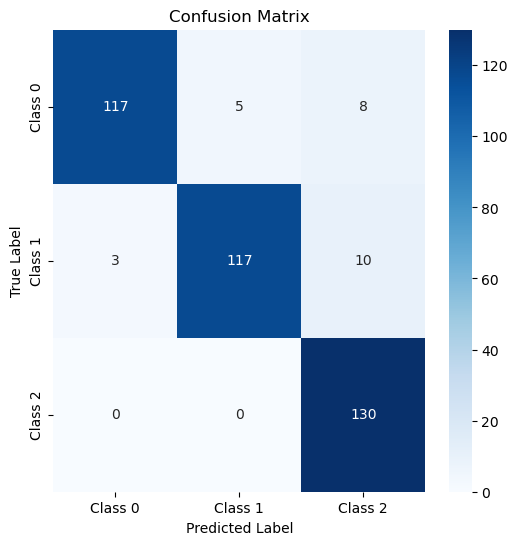

In [10]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], 
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

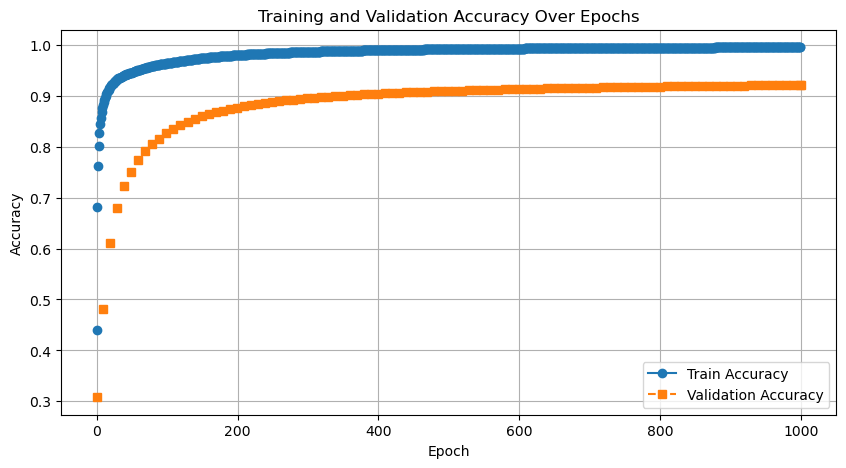

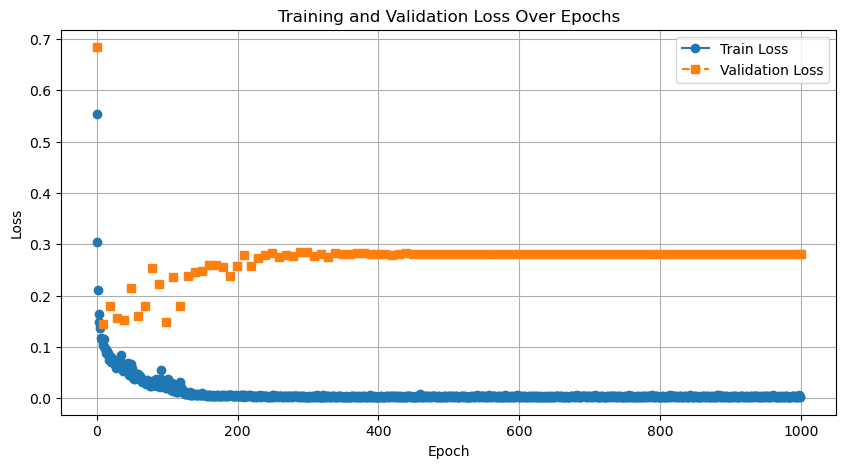

In [11]:
# Drop rows where 'epoch' is NaN (some rows are intermediate step logs)
df = pd.read_csv("/home/valentin/workspaces/histomil/lightning_logs/version_50/metrics.csv")
df = df.dropna(subset=['epoch'])

# Convert to numeric types
df['epoch'] = df['epoch'].astype(int)
df['train_acc_epoch'] = pd.to_numeric(df['train_acc_epoch'], errors='coerce')
df['train_loss_epoch'] = pd.to_numeric(df['train_loss_epoch'], errors='coerce')
df['val_acc'] = pd.to_numeric(df['val_acc'], errors='coerce')
df['val_loss'] = pd.to_numeric(df['val_loss'], errors='coerce')

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_acc_epoch'], label="Train Accuracy", marker='o', linestyle='-')
plt.plot(df['epoch'], df['val_acc'], label="Validation Accuracy", marker='s', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss_epoch'], label="Train Loss", marker='o', linestyle='-')
plt.plot(df['epoch'], df['val_loss'], label="Validation Loss", marker='s', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
